In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
DATA_PATH = os.path.join(cwd, 'data')
class_names = os.listdir(DATA_PATH)

Number of broken_pipe images: 466
*****************Visualize Random Images of broken_pipe**************************


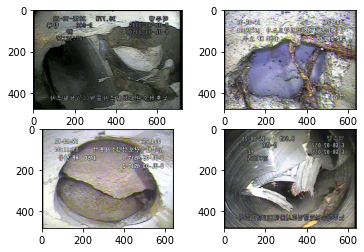

Number of deposits_silty images: 325
*****************Visualize Random Images of deposits_silty**************************


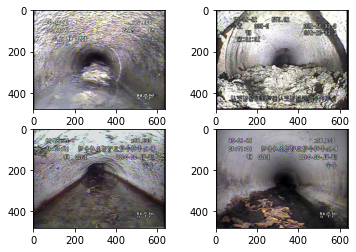

Number of horizontal images: 426
*****************Visualize Random Images of horizontal**************************


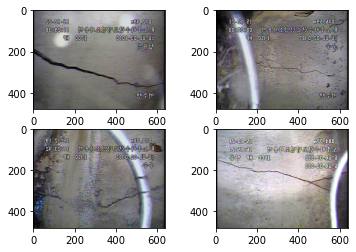

Number of joint_faulty images: 485
*****************Visualize Random Images of joint_faulty**************************


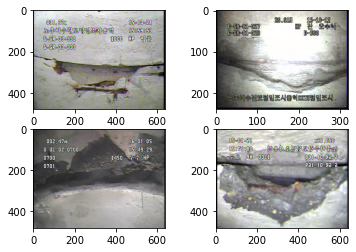

Number of joint_open images: 503
*****************Visualize Random Images of joint_open**************************


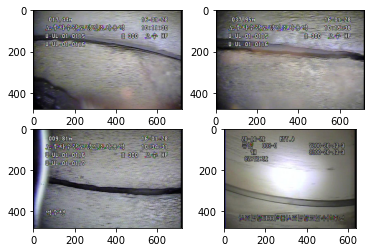

Number of lateral_protruding images: 453
*****************Visualize Random Images of lateral_protruding**************************


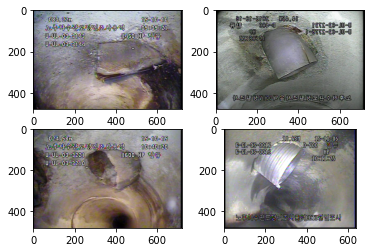

Number of surface_damage images: 476
*****************Visualize Random Images of surface_damage**************************


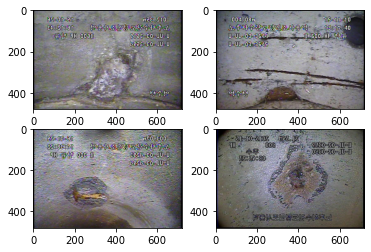

Number of vertical images: 454
*****************Visualize Random Images of vertical**************************


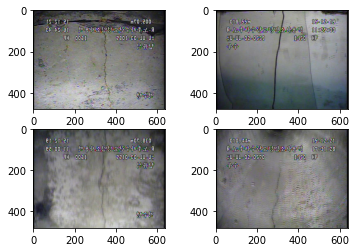

In [3]:
## Visualize Random images

# 각 label 별 임의로 4장을 시각화
for label in class_names:
    images = os.listdir(os.path.join(DATA_PATH ,label))
    print("Number of {} images: {}".format(label, len(images)))
    random_indices = np.random.randint(0, len(images), size=4)
    print("*****************Visualize Random Images of %s**************************" % label)
    random_images = np.array(images)[random_indices]
    
    f, axarr = plt.subplots(2, 2)
    axarr[0,0].imshow(mpimg.imread(os.path.join(DATA_PATH, label, random_images[0])))
    axarr[0,1].imshow(mpimg.imread(os.path.join(DATA_PATH, label, random_images[1])))
    axarr[1,0].imshow(mpimg.imread(os.path.join(DATA_PATH, label, random_images[2])))
    axarr[1,1].imshow(mpimg.imread(os.path.join(DATA_PATH, label, random_images[3])))
    plt.show()

# Create Train and Val Datasets

In [4]:
def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    files = os.listdir(os.path.join(base_dir, folder_name))

    shutil.move(f'{base_dir}/{folder_name}', train_dir)
    print("%s Complete!!" % folder_name)

In [5]:
# Create Training Folder
base_dir = DATA_PATH
for label in class_names:
    create_training_data(label)

broken_pipe Complete!!
deposits_silty Complete!!
horizontal Complete!!
joint_faulty Complete!!
joint_open Complete!!
lateral_protruding Complete!!
surface_damage Complete!!
vertical Complete!!


In [6]:
# Move images randomly from training to val folders

for label in class_names:
    val_folder_name = os.path.join(base_dir, 'val', label)
    try:
        os.makedirs(val_folder_name)
    except FileExistsError:
        print("Folder already exist")

In [7]:
train_dir = base_dir + '/train'
val_dir = base_dir + '/val'

In [8]:
# Training 데이터의 2할을 Validation으로 나누어 저장
for label in class_names:
    label_train = os.path.join(train_dir, label)
    label_files = os.listdir(label_train)
    for f in label_files:
        if random.random() > 0.80:
            shutil.move(f'{label_train}/{f}', f'{val_dir}/{label}')

Number of Validation broken_pipe images:  466
Number of Validation deposits_silty images:  325
Number of Validation horizontal images:  426
Number of Validation joint_faulty images:  485
Number of Validation joint_open images:  503
Number of Validation lateral_protruding images:  453
Number of Validation surface_damage images:  476
Number of Validation vertical images:  454


In [17]:
for label in os.listdir(val_dir):
    val_label_dir = os.path.join(val_dir, label)
    print("Number of Validation", label, "images: ", len(os.listdir(val_label_dir)))

Number of Validation broken_pipe images:  101
Number of Validation deposits_silty images:  65
Number of Validation horizontal images:  77
Number of Validation joint_faulty images:  89
Number of Validation joint_open images:  110
Number of Validation lateral_protruding images:  101
Number of Validation surface_damage images:  80
Number of Validation vertical images:  98


# Pytorch data loader and transforms

In [11]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [12]:
## Define data augmentation and transforms
chosen_transforms = {'data/train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'data/val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [13]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [14]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
train_loader, train_size, class_names = load_dataset('data/train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  2867
Class Names are:  ['broken_pipe', 'deposits_silty', 'horizontal', 'joint_faulty', 'joint_open', 'lateral_protruding', 'surface_damage', 'vertical']
torch.Size([8, 3, 227, 227]) torch.Size([8])


# Visualize the Augmented Dataset

In [19]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

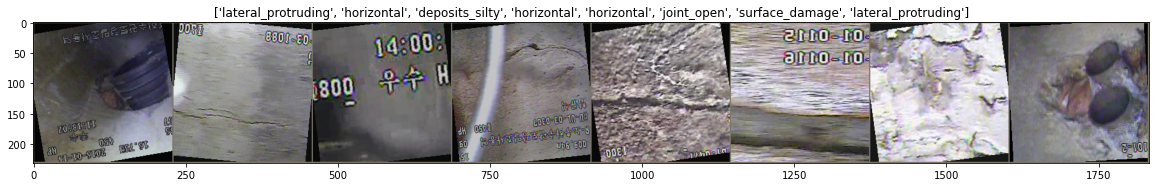

In [21]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20,10))
imshow(out, title=[class_names[int(x.data.numpy())] for x in classes])

# Set up Pretrained Model

In [22]:
CLASS_NUM = len(class_names)

## Load pretrained model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, CLASS_NUM)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [23]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [24]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('data/train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('data/val', batch_size)
for idx, label in enumerate(class_names):
    idx_to_class[idx] = label

# Start Training

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer.step()
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...
train Loss: 1.7132 Acc: 0.4077
Iterating through data...
val Loss: 1.5899 Acc: 0.5479

Epoch 1/5
----------
Iterating through data...
train Loss: 1.7098 Acc: 0.4203
Iterating through data...
val Loss: 1.5888 Acc: 0.5520

Epoch 2/5
----------
Iterating through data...
train Loss: 1.7172 Acc: 0.3966
Iterating through data...
val Loss: 1.5893 Acc: 0.5534

Epoch 3/5
----------
Iterating through data...
train Loss: 1.7085 Acc: 0.4193
Iterating through data...
val Loss: 1.5869 Acc: 0.5562

Epoch 4/5
----------
Iterating through data...
train Loss: 1.7134 Acc: 0.4123
Iterating through data...
val Loss: 1.5858 Acc: 0.5631

Epoch 5/5
----------
Iterating through data...
train Loss: 1.7209 Acc: 0.4004
Iterating through data...
val Loss: 1.5849 Acc: 0.5576

Training complete in 2m 3s
Best val Acc: 0.563107


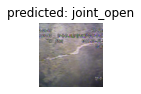

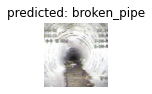

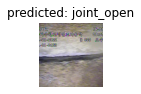

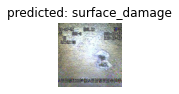

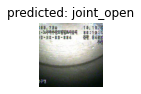

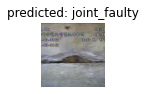

In [44]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=30)
visualize_model(base_model)
plt.show()

# Inference

In [45]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x
    
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x

In [46]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda=True):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

## GradCAM 적용

In [47]:
grad_cam = GradCam(model=base_model, feature_module=base_model.layer4, target_layer_names=["2"], use_cuda=True)

In [48]:
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    
    return cam

def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['data/val']
     
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [51]:
test_img_dir = os.path.join(base_dir, 'test_image')
GradCAM_dir = os.path.join(cwd, 'GradCAM')

if not os.path.isdir(GradCAM_dir):
    os.makedirs(GradCAM_dir)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
cnt = 1
for image in os.listdir(test_img_dir):
    img = cv2.imread(os.path.join(test_img_dir, image), 1)
    # 예측한 클래스를 파일의 제목으로 지정
    predicted_class = predict(base_model, Image.fromarray(img))

    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)
    target_index = None
    mask = grad_cam(input, target_index)
    cam = show_cam_on_image(img, mask)
    
    saved_name = GradCAM_dir + "/" + predicted_class + str(cnt) + ".jpg"    
    cv2.imwrite(saved_name, np.uint8(255 * cam))
    cnt += 1

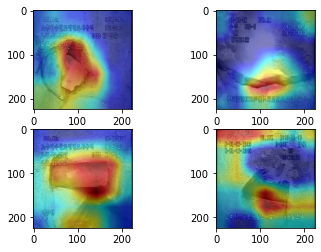

In [36]:
# GradCAM 결과 중 랜덤하게 4장만 가져와 시각화

inference_files = os.listdir(GradCAM_dir)

random_indices = np.random.randint(0, len(inference_files), size=4)
random_images = np.array(inference_files)[random_indices]

f, axarr = plt.subplots(2, 2)
axarr[0,0].imshow(mpimg.imread(os.path.join(GradCAM_dir, random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(GradCAM_dir, random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(GradCAM_dir, random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(GradCAM_dir, random_images[3])))
plt.show()

In [39]:
chosen_transforms['data/test'] = transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
])

In [41]:
# Make test folders
test_dir = os.path.join(base_dir, 'test')

for label in class_names:
    test_folder_name = os.path.join(test_dir, label)
    try:
        os.makedirs(test_folder_name)
    except FileExistsError:
        print("Folder already exist")

In [42]:
test_loader, test_size, test_names = load_dataset('data/test', 1)
print("Test Data Set size is: ", test_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(test_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  492
Class Names are:  ['broken_pipe', 'deposits_silty', 'horizontal', 'joint_faulty', 'joint_open', 'lateral_protruding', 'surface_damage', 'vertical']
torch.Size([1, 3, 227, 227]) torch.Size([1])
